In [1]:
## READ IN TRAINING DATA ##

import pandas as pd

df = pd.read_csv('../data/train.csv', header=0)

df_edit = df.copy()

In [2]:
## REMOVE/REPLACE MISSING OR NaN VALUES ##
# Age, Cabin and Embarked all have at least one NaN value

import numpy as np

# Create new numerical mapping of Sex, Gender
df_edit['Gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)

# Assign missing Age based on median ages of Gender and Class
median_ages = np.zeros((2,3)) # make new table for median ages for each gender and class
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df_edit[(df_edit['Gender'] == i) & (df_edit['Pclass'] == j+1)]['Age'].dropna().median()

for i in range(0, 2):
    for j in range(0, 3):
        df_edit.loc[(df_edit['Age'].isnull()) & (df_edit['Gender'] == i) & (df_edit['Pclass'] == j+1), 'Age'] = median_ages[i,j]

# Assign missing Fare based on median Fare for each class
median_fares = [0,0,0]
for i in range(0,3):
    median_fares[i] = df_edit[(df_edit['Pclass'] == i+1)]['Fare'].dropna().median()
    
for i in range(0,3):
    df_edit.loc[(df_edit['Fare'].isnull()) & (df_edit['Pclass'] == i+1), 'Fare'] = median_fares[i]  

# Assign missing Cabin as unknown indicator "X0"
df_edit['Cabin'][df_edit['Cabin'].isnull()] = 'X0'

# Assign missing Embarked most common port (Southampton)
df_edit['Embarked'][df_edit['Embarked'].isnull()] = df['Embarked'].dropna().mode().values

-c:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
## VARIABLE MANAGEMENT AND DERIVATION ##

# Create new numerical mapping of Embarked, Port
df_edit['Port'] = df_edit['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [4]:
## DROP ALL OBJECT FEATURES AND SCALE ##

from sklearn import preprocessing

df_reduced = df_edit.copy()

df_reduced = df_reduced.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)

scaler = preprocessing.StandardScaler()
for col in df_reduced:
    if col!='PassengerId' and col!='Survived':
        df_reduced[col] = scaler.fit_transform(df_reduced[col])

/opt/anaconda/envs/np18py27-1.9/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [5]:
## MODEL USING RANDOM FOREST CLASSIFIER ON TRAINING DATA ##

from sklearn.ensemble import RandomForestClassifier

df_ready = df_reduced.copy()

# Split data into thirds to create three tests
df_third1 = df_ready[:297]
df_third2 = df_ready[297:594]
df_third3 = df_ready[594:]

df_train1 = pd.concat([df_third2, df_third3])
df_train2 = pd.concat([df_third1, df_third3])
df_train3 = pd.concat([df_third1, df_third2])

# Test 1: Train on thirds 2, 3, test on third 1
forest = RandomForestClassifier(n_estimators=1000, random_state=3)
forest = forest.fit(df_train1.values[0::,2::], df_train1.values[0::,1])
output1 = forest.predict(df_third1.values[0::,2::])

# Test 2: Train on thirds 1, 3, test on third 2
forest = RandomForestClassifier(n_estimators=1000, random_state=3)
forest = forest.fit(df_train2.values[0::,2::], df_train2.values[0::,1])
output2 = forest.predict(df_third2.values[0::,2::])

# Test 3: Train on thirds 1, 2, test on third 3
forest = RandomForestClassifier(n_estimators=1000, random_state=3)
forest = forest.fit(df_train3.values[0::,2::], df_train3.values[0::,1])
output3 = forest.predict(df_third3.values[0::,2::])

In [6]:
## CALCULATE SCORE ##

from sklearn.metrics import f1_score

df_pred1 = pd.DataFrame(output1, columns=['Prediction'])
df_pred2 = pd.DataFrame(output2, columns=['Prediction'])
df_pred2.index += 297
df_pred3 = pd.DataFrame(output3, columns=['Prediction'])
df_pred3.index += 594

df_pred1['Survived'] = df_third1['Survived']
df_pred2['Survived'] = df_third2['Survived']
df_pred3['Survived'] = df_third3['Survived']

df_pred1['Correct'] = df_pred1['Prediction'] == df_pred1['Survived']
df_pred2['Correct'] = df_pred2['Prediction'] == df_pred2['Survived']
df_pred3['Correct'] = df_pred3['Prediction'] == df_pred3['Survived']

score = (df_pred1['Correct'].sum() + df_pred2['Correct'].sum() + df_pred3['Correct'].sum()) / 891.0
print score

df_fullpred = pd.concat([df_pred1, df_pred2, df_pred3])
print f1_score(df_fullpred['Prediction'].values, df_fullpred['Survived'].values)

0.794612794613
0.72808320951


ROC AUC: 0.85


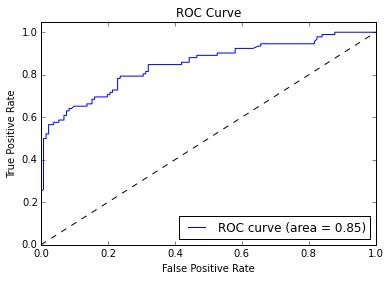

In [15]:
## ROC CURVE ##

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

X = df_ready.values[0::,2::]
y = df_ready.values[0::,1]
 
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
forest.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
## SVM ##

from sklearn import svm
from sklearn.metrics import f1_score

# Split data into thirds to create three tests
df_third1 = df_ready[:297]
df_third2 = df_ready[297:594]
df_third3 = df_ready[594:]

df_train1 = pd.concat([df_third2, df_third3])
df_train2 = pd.concat([df_third1, df_third3])
df_train3 = pd.concat([df_third1, df_third2])

# Test 1: Train on thirds 2, 3, test on third 1
clf = svm.SVC()
clf = clf.fit(df_train1.values[0::,2::], df_train1.values[0::,1])
output1 = clf.predict(df_third1.values[0::,2::])

# Test 2: Train on thirds 1, 3, test on third 2
clf = svm.SVC()
clf = clf.fit(df_train2.values[0::,2::], df_train2.values[0::,1])
output2 = clf.predict(df_third2.values[0::,2::])

# Test 3: Train on thirds 1, 2, test on third 3
clf = svm.SVC(probability=True)
clf = clf.fit(df_train3.values[0::,2::], df_train3.values[0::,1])
output3 = clf.predict(df_third3.values[0::,2::])

df_pred1 = pd.DataFrame(output1, columns=['Prediction'])
df_pred2 = pd.DataFrame(output2, columns=['Prediction'])
df_pred2.index += 297
df_pred3 = pd.DataFrame(output3, columns=['Prediction'])
df_pred3.index += 594

df_pred1['Survived'] = df_third1['Survived']
df_pred2['Survived'] = df_third2['Survived']
df_pred3['Survived'] = df_third3['Survived']

df_pred1['Correct'] = df_pred1['Prediction'] == df_pred1['Survived']
df_pred2['Correct'] = df_pred2['Prediction'] == df_pred2['Survived']
df_pred3['Correct'] = df_pred3['Prediction'] == df_pred3['Survived']

score = (df_pred1['Correct'].sum() + df_pred2['Correct'].sum() + df_pred3['Correct'].sum()) / 891.0
print score

df_fullpred = pd.concat([df_pred1, df_pred2, df_pred3])
print f1_score(df_fullpred['Prediction'].values, df_fullpred['Survived'].values)

0.830527497194
0.759170653907


ROC AUC: 0.85


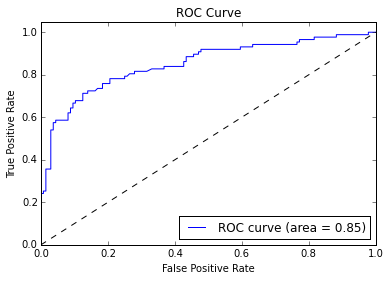

In [9]:
## ROC CURVE (SVM) ##

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

X = df_ready.values[0::,2::]
y = df_ready.values[0::,1]
 
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
clf.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()